In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import utils
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# 1. Data Cleaning

In [2]:
# import the data
df = pd.read_csv("application_data.csv")
# shuffle the data
df = utils.shuffle(df)
df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
283032,427824,0,Cash loans,F,N,N,0,157500.0,1078200.0,31653.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
120394,239596,0,Cash loans,F,N,N,0,97875.0,1260000.0,31981.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
68812,179809,0,Revolving loans,M,Y,Y,1,135000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
281850,426482,0,Cash loans,F,N,Y,0,198000.0,1346089.5,42264.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
77054,189350,0,Cash loans,F,N,N,0,40500.0,95940.0,9616.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
204073,336590,0,Cash loans,F,Y,Y,0,69750.0,256500.0,16699.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
53995,162561,0,Cash loans,F,N,Y,1,202500.0,381528.0,22032.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
211707,345334,0,Cash loans,F,N,Y,0,157500.0,795465.0,31675.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
93797,208915,0,Cash loans,F,N,Y,3,157500.0,973710.0,28597.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
161633,287382,0,Cash loans,F,N,Y,0,180000.0,1310409.0,38443.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
# select columns based on the column description
df = df[["TARGET", "NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN",
         "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE",
         "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "DAYS_BIRTH", "DAYS_EMPLOYED",
         "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "AMT_CREDIT"]]

# rename the columns 
df = df.rename(columns = {"TARGET": "Late_payment_before", "NAME_CONTRACT_TYPE": "Loan_type", "CODE_GENDER": "Gender",
                          "FLAG_OWN_CAR": "Own_car", "FLAG_OWN_REALTY": "Own_realty", "CNT_CHILDREN": "Number_of_children",
                          "AMT_INCOME_TOTAL": "Annual_income", "AMT_GOODS_PRICE": "Goods_price", "NAME_INCOME_TYPE": "Income_type",
                          "NAME_EDUCATION_TYPE": "Educational_level", "NAME_FAMILY_STATUS": "Marriege_status","NAME_HOUSING_TYPE": "Housing_type",
                          "DAYS_BIRTH": "Age", "DAYS_EMPLOYED": "Working_length", "OCCUPATION_TYPE": "Occupation_type",
                          "CNT_FAM_MEMBERS": "Number_of_family_member", "REGION_RATING_CLIENT": "Living_region_rating","AMT_CREDIT": "Amount_issued"})

# drop the Nah
df = df.dropna()

In [4]:
# day to year
def day_to_year(num):
    return round(- num / 365, 2)

df["Age"] = df["Age"].apply(day_to_year)
df["Working_length"] = df["Working_length"].apply(day_to_year)

Plotting for column Late_payment_before


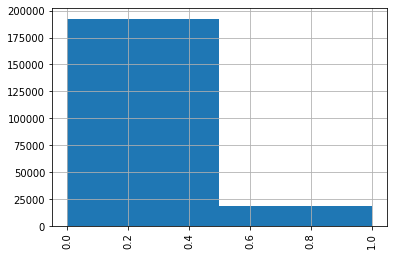

Plotting for column Loan_type


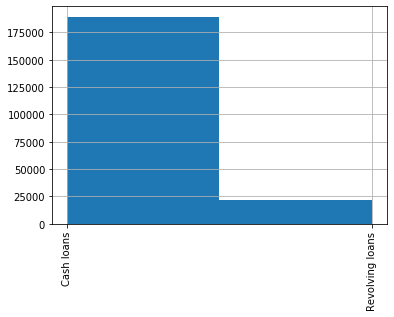

Plotting for column Gender


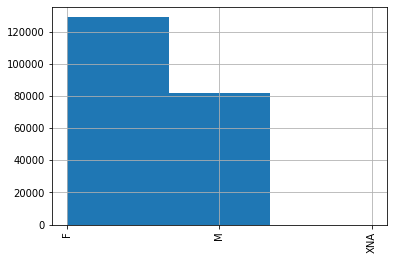

Plotting for column Own_car


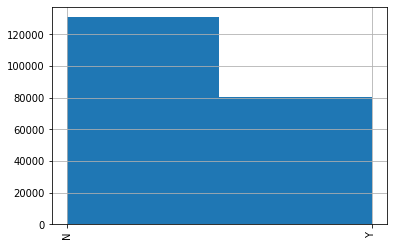

Plotting for column Own_realty


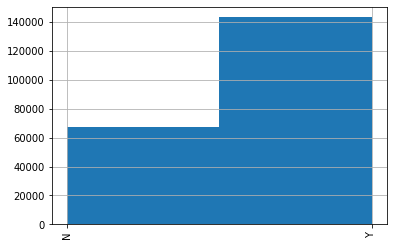

Plotting for column Number_of_children


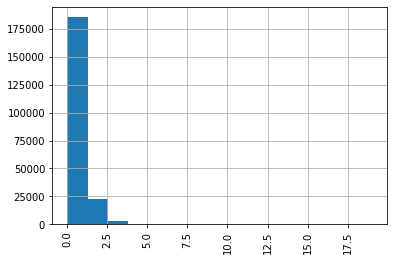

Plotting for column Annual_income


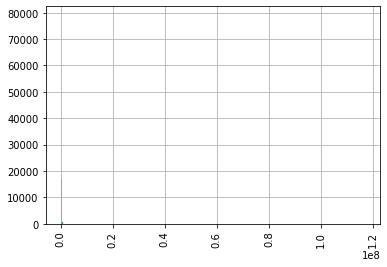

Plotting for column Goods_price


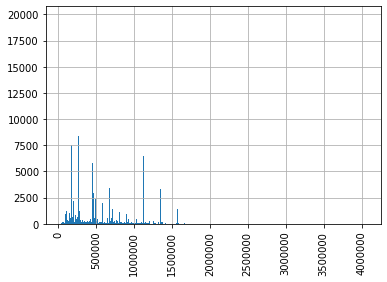

Plotting for column Income_type


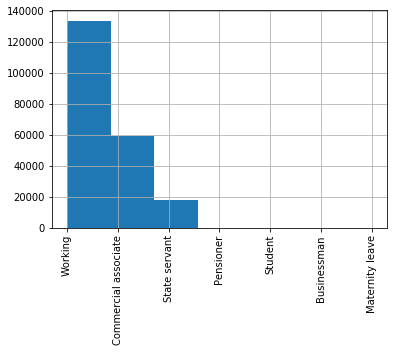

Plotting for column Educational_level


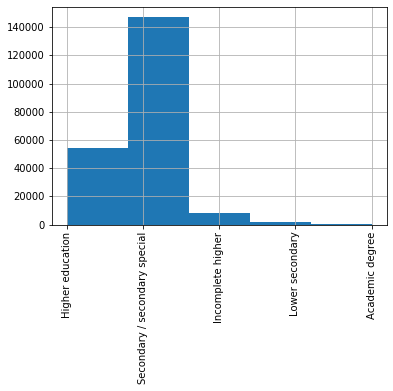

Plotting for column Marriege_status


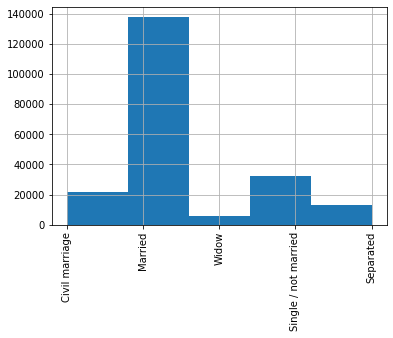

Plotting for column Housing_type


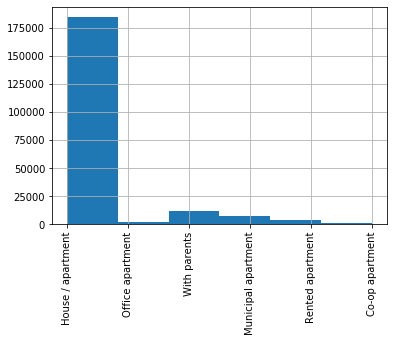

Plotting for column Age


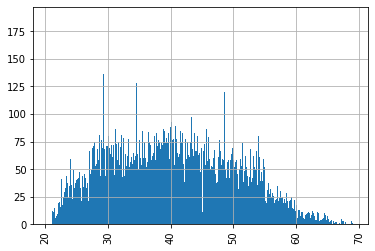

Plotting for column Working_length


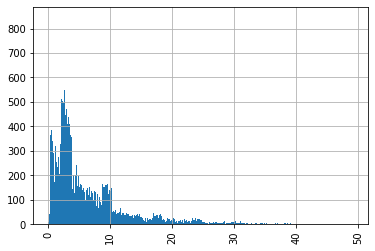

Plotting for column Occupation_type


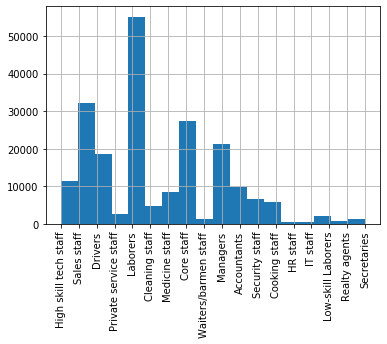

Plotting for column Number_of_family_member


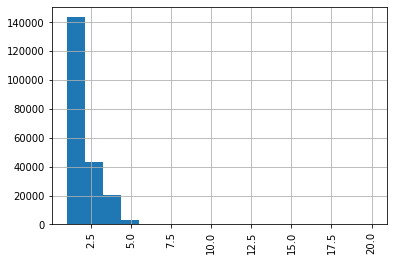

Plotting for column Living_region_rating


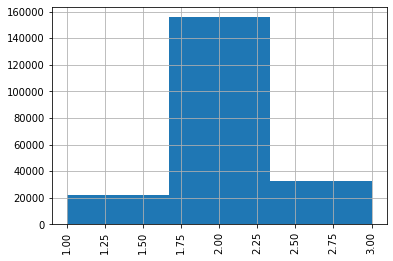

Plotting for column Amount_issued


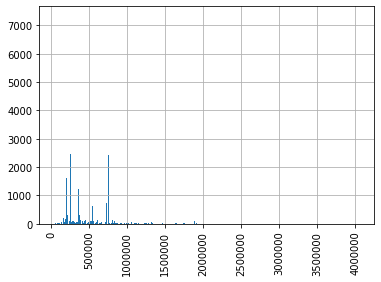

In [5]:
# show data description
for col in df.columns:
    hist = df[col].hist(bins = len(list(df[col].unique())))
    plt.xticks(rotation = "vertical")
    print("Plotting for column {}".format(col))
    plt.show()

In [6]:
def get_sub_Xi(df, x):
    return list(df[x].unique())

# normalize train x_df
def normalize_one_column(x, df):
    sub_x_list = get_sub_Xi(df, x)
    for sub_x in sub_x_list:
        df[x].replace({sub_x : sub_x_list.index(sub_x)}, inplace = True)

In [7]:
# normalize the data
features_need_normalize = ["Gender", "Own_car", "Own_realty", "Income_type", "Educational_level", "Marriege_status", "Housing_type", "Occupation_type"]

for feature in features_need_normalize:
    normalize_one_column(feature, df)

In [8]:
# divide the the data into two parts
cash_loan_df = df[df["Loan_type"] == "Cash loans"].dropna().drop(columns = ["Loan_type"])
revolving_loan_df = df[df["Loan_type"] == "Revolving loans"].dropna().drop(columns = ["Loan_type"])

In [9]:
# split the data into train and test
def data_preparation(df):
    
    # define split
    split = int(len(df) * 3 / 4)
    
    # prepare training and testing data
    x, y = df.loc[:, df.columns != 'Amount_issued'], df['Amount_issued']
    x_train, x_test = x.iloc[:split], x.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    return x_train, y_train, x_test, y_test

In [10]:
result_dic = {}
def get_metrics(x, y, model, name, add_information):
    # get predicted value
    y_predict = model.predict(x)
    # calculate the rmse
    rmse = np.sqrt(mean_squared_error(y, y_predict))
    # calculate r2 score
    r2 = r2_score(y, y_predict)
    
    print("RMSE:", rmse, "\nR2 score:", r2)
    #update result_dic
    if add_information:
        result_dic[name] = [name, rmse, r2]

# 2. Cash Loan

In [11]:
cash_loan_df.head(5)

,Late_payment_before,Gender,Own_car,Own_realty,Number_of_children,Annual_income,Goods_price,Income_type,Educational_level,Marriege_status,Housing_type,Age,Working_length,Occupation_type,Number_of_family_member,Living_region_rating,Amount_issued
283032,0,0,0,0,0,157500.0,900000.0,0,0,0,0,30.45,8.58,0,2.0,3,1078200.0
120394,0,0,0,0,0,97875.0,1260000.0,1,1,1,0,55.82,3.03,1,2.0,1,1260000.0
93797,0,0,0,1,3,157500.0,697500.0,1,1,1,0,29.51,2.50,0,5.0,1,973710.0
161633,0,0,0,1,0,180000.0,1026000.0,1,1,0,0,48.30,4.33,3,2.0,2,1310409.0
270948,0,0,1,1,2,202500.0,1350000.0,1,1,1,0,36.38,4.45,3,4.0,2,1546020.0


In [12]:
# define scaler, use standard scaler
scaler = StandardScaler()

features = list(cash_loan_df.columns)[:-1]
# use stardard scaler to scale data, used for gradient descent
cash_loan_df[features] = scaler.fit_transform(cash_loan_df[list(features)])

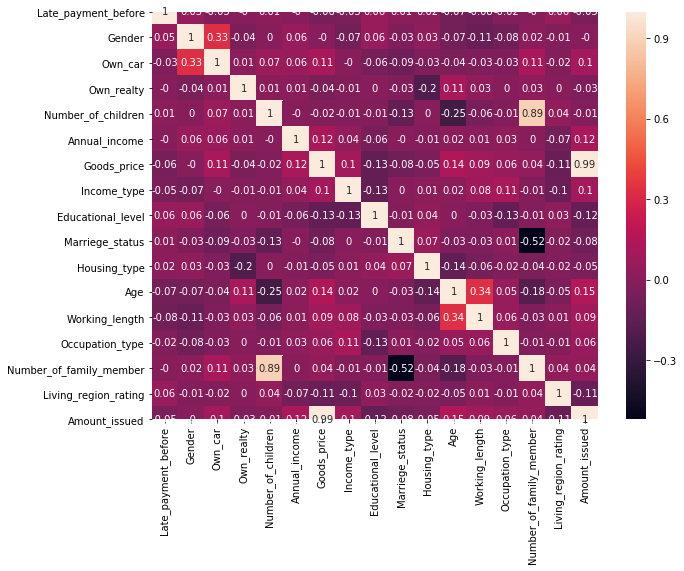

In [13]:
correlation_matrix = cash_loan_df.corr().round(2)

plt.subplots(figsize=(10, 7.5))
sns.heatmap(data = correlation_matrix, annot = True)

In [14]:
# calculate the correlation coefficient
cash_loan_df.corr().round(2).iloc[:, -1]

Late_payment_before       -0.05
Gender                    -0.00
Own_car                    0.10
Own_realty                -0.03
Number_of_children        -0.01
Annual_income              0.12
Goods_price                0.99
Income_type                0.10
Educational_level         -0.12
Marriege_status           -0.08
Housing_type              -0.05
Age                        0.15
Working_length             0.09
Occupation_type            0.06
Number_of_family_member    0.04
Living_region_rating      -0.11
Amount_issued              1.00
Name: Amount_issued, dtype: float64

In [15]:
# prepare the data
x_train, y_train, x_test, y_test = data_preparation(cash_loan_df)

## 2.1 Linear Regression

In [16]:
# train by linear regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
print("Performance on Training set:")
get_metrics(x_train, y_train, mlr, "Linear Regression", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, mlr, "Linear Regression", True)

Performance on Training set:
RMSE: 66835.55441641773 
R2 score: 0.9731668840365229

Performance on Testing set:
RMSE: 67001.60456802639 
R2 score: 0.9730877561284491


## 2.2 Polynomial Regression

In [18]:
dic = {}
l_r2 = []
for i in range(1, 4):
    
    poly = PolynomialFeatures(degree = i)
    poly_x_train = poly.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(poly_x_train, y_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, poly_reg.predict(poly_x_train)))
    r2 = r2_score(y_train, poly_reg.predict(poly_x_train))
    
    dic[i] = [i, rmse, r2]

poly_train_result = pd.DataFrame.from_dict(dic, orient = 'index', columns = ["Degree", "RMSE", "R2"])  
display(poly_train_result.set_index("Degree"))

,RMSE,R2
Degree,,
1,66835.554416,0.973167
2,65552.368696,0.974187
3,64870.025947,0.974722


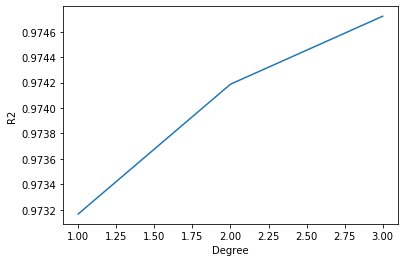

In [19]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "R2", markers = True)

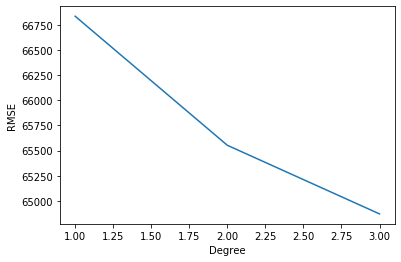

In [20]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "RMSE", markers = True)

In [21]:
# from the figure above, the best degree is 3
poly = PolynomialFeatures(degree = 3)
poly_x_train = poly.fit_transform(x_train)
poly_x_test = poly.fit_transform(x_test)
poly_reg = LinearRegression()
poly_reg.fit(poly_x_train, y_train)
    
print("Performance on Training set:")
get_metrics(poly_x_train, y_train, poly_reg, "Polynomial Regression", False)
print("\nPerformance on Testing set:")
get_metrics(poly_x_test, y_test, poly_reg, "Polynomial Regression", True)

Performance on Training set:
RMSE: 64870.02594663745 
R2 score: 0.974721916688956

Performance on Testing set:
RMSE: 65434.117959783965 
R2 score: 0.9743322377495632


## 2.3 Ridge

In [22]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train ridge model
    ridge = Ridge(alpha = n)
    ridge.fit(x_train, y_train)
    
    # rmse, r2 for train
    ridge_train_predict = ridge.predict(x_train)
    ridge_train_mse = mean_squared_error(y_train, ridge_train_predict)
    ridge_train_rmse = (np.sqrt(ridge_train_mse))
    ridge_train_r2 = r2_score(y_train, ridge_train_predict)
    
    dic[n] = [n, ridge_train_rmse, ridge_train_r2]
    
ridge_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(ridge_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,66835.554416,0.973167
0.010,66835.554416,0.973167
0.100,66835.554417,0.973167
10.000,66835.561622,0.973167
30.000,66835.619148,0.973167
50.000,66835.733912,0.973167
60.000,66835.812667,0.973167
70.000,66835.905623,0.973167
80.000,66836.012746,0.973167


In [23]:
# from the table above, when alpha = 0.01, the ridge performs best

# train ridge model
ridge = Ridge(alpha = 0.01)
ridge.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, ridge, "Ridge", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, ridge, "Ridge", True)

Performance on Training set:
RMSE: 66835.55441642494 
R2 score: 0.973166884036517

Performance on Testing set:
RMSE: 67001.60428633368 
R2 score: 0.9730877563547417


## 2.4 Lasso

In [24]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train lasso model
    lasso = Lasso(alpha = n)
    lasso.fit(x_train, y_train)
    
    # rmse, r2 for train
    lasso_train_predict = lasso.predict(x_train)
    lasso_train_mse = mean_squared_error(y_train, lasso_train_predict)
    lasso_train_rmse = (np.sqrt(lasso_train_mse))
    lasso_train_r2 = r2_score(y_train, lasso_train_predict)
    
    dic[n] = [n, lasso_train_rmse, lasso_train_r2]
    
lasso_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(lasso_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,66835.554416,0.973167
0.010,66835.554417,0.973167
0.100,66835.554431,0.973167
10.000,66835.702981,0.973167
30.000,66836.886487,0.973166
50.000,66839.252674,0.973164
60.000,66840.869690,0.973163
70.000,66842.444938,0.973161
80.000,66842.844951,0.973161


In [25]:
# from the table above, when alpha = 0.01, the lasso performs best

# train ridge model
lasso = Lasso(alpha = 0.01)
lasso.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, lasso, "Lasso", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, lasso, "Lasso", True)

Performance on Training set:
RMSE: 66835.55441656642 
R2 score: 0.9731668840364034

Performance on Testing set:
RMSE: 67001.6050648537 
R2 score: 0.9730877557293321


## 2.5 Regression Tree

In [26]:
def cross_validation_on_regression_tree(x, y, depths, cv):
    cv_scores_list = []

    for i in depths:
        tree_model = DecisionTreeRegressor(max_depth = i)
        cv_score = cross_val_score(tree_model, x, y, cv=cv, scoring = "r2").mean()
        cv_scores_list.append(cv_score)
    return cv_scores_list

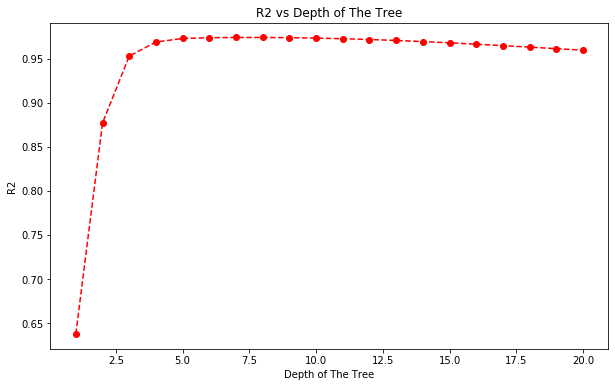

In [27]:
plt.figure(figsize = (10, 6))
cv_score_list = cross_validation_on_regression_tree(x_train, y_train, range(1, 21), 10)

plt.plot(range(1, 21), cv_score_list, color = "red", marker = 'o', linestyle = '--')  
plt.xlabel('Depth of The Tree')
plt.ylabel('R2')
plt.title('R2 vs Depth of The Tree')
plt.show()

In [28]:
# from the figure, the regression tree performs best at depth 6
reg_tree = DecisionTreeRegressor(max_depth = 6)
reg_tree.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, reg_tree, "Regression Tree", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, reg_tree, "Regression Tree", True)

Performance on Training set:
RMSE: 65676.11330688145 
R2 score: 0.9740897928899853

Performance on Testing set:
RMSE: 66078.14567611611 
R2 score: 0.973824487303169


In [29]:
result = pd.DataFrame.from_dict(result_dic, orient = 'index', 
                                columns = ["Model", "RMSE", "R_2"])
display(result.set_index("Model"))

,RMSE,R_2
Model,,
Linear Regression,67001.604568,0.973088
Polynomial Regression,65434.117960,0.974332
Ridge,67001.604286,0.973088
Lasso,67001.605065,0.973088
Regression Tree,66078.145676,0.973824


# 3. Revolving Loan

In [30]:
revolving_loan_df.head(10)

,Late_payment_before,Gender,Own_car,Own_realty,Number_of_children,Annual_income,Goods_price,Income_type,Educational_level,Marriege_status,Housing_type,Age,Working_length,Occupation_type,Number_of_family_member,Living_region_rating,Amount_issued
68812,0,1,1,1,1,135000.0,202500.0,0,1,1,0,50.86,20.10,2,3.0,2,202500.0
162746,0,0,1,0,0,202500.0,180000.0,2,0,3,2,27.51,4.72,0,1.0,3,180000.0
163902,0,0,0,0,0,90000.0,270000.0,1,0,3,2,23.62,2.66,7,1.0,2,270000.0
253807,0,0,0,1,1,112500.0,180000.0,2,0,1,2,27.55,2.70,7,3.0,3,180000.0
130734,0,1,0,1,1,90000.0,180000.0,0,1,1,0,27.45,0.28,4,3.0,2,180000.0
302697,0,1,1,0,2,180000.0,270000.0,2,0,1,0,28.89,7.21,14,4.0,3,270000.0
226114,1,0,0,1,1,112500.0,405000.0,0,0,3,0,35.63,2.82,7,2.0,3,405000.0
265593,1,0,1,1,0,157500.0,202500.0,0,1,1,0,49.39,2.73,15,2.0,2,202500.0
103146,0,0,0,1,1,54000.0,157500.0,0,0,1,0,49.22,9.92,14,3.0,2,157500.0
58555,0,1,1,1,0,121500.0,247500.0,1,1,1,0,49.96,0.39,4,2.0,2,247500.0


In [31]:
# define scaler, use standard scaler
scaler = StandardScaler()

features = list(revolving_loan_df.columns)[:-1]
# use stardard scaler to scale data, used for gradient descent
revolving_loan_df[features] = scaler.fit_transform(revolving_loan_df[list(features)])

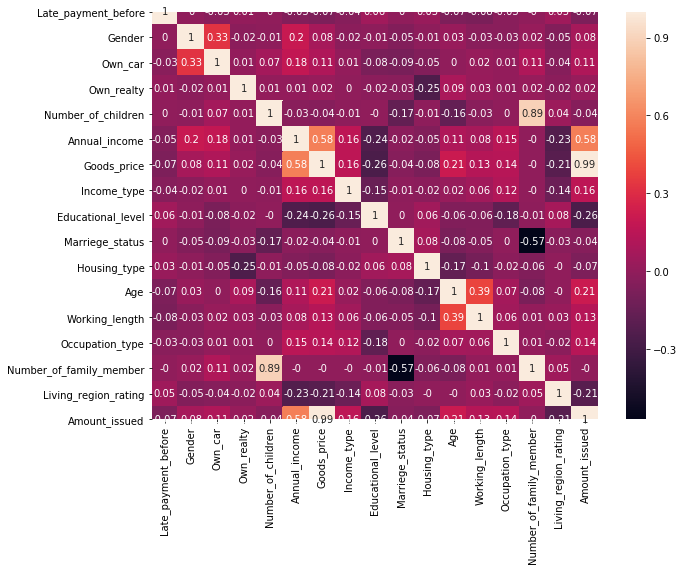

In [32]:
correlation_matrix = revolving_loan_df.corr().round(2)

plt.subplots(figsize=(10, 7.5))
sns.heatmap(data = correlation_matrix, annot = True)

In [33]:
# calculate the correlation coefficient
revolving_loan_df.corr().round(2).iloc[:, -1]

Late_payment_before       -0.07
Gender                     0.08
Own_car                    0.11
Own_realty                 0.02
Number_of_children        -0.04
Annual_income              0.58
Goods_price                0.99
Income_type                0.16
Educational_level         -0.26
Marriege_status           -0.04
Housing_type              -0.07
Age                        0.21
Working_length             0.13
Occupation_type            0.14
Number_of_family_member   -0.00
Living_region_rating      -0.21
Amount_issued              1.00
Name: Amount_issued, dtype: float64

In [34]:
# prepare the data
x_train, y_train, x_test, y_test = data_preparation(revolving_loan_df)

## 3.1 Linear Regression

In [35]:
# train by linear regression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
print("Performance on Training set:")
get_metrics(x_train, y_train, mlr, "Linear Regression", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, mlr, "Linear Regression", True)

Performance on Training set:
RMSE: 25074.95042552464 
R2 score: 0.9884303815842378

Performance on Testing set:
RMSE: 22472.320527689993 
R2 score: 0.9908233670725238


## 3.2 Polynomial Regression

In [37]:
dic = {}
l_r2 = []
for i in range(1, 4):
    
    poly = PolynomialFeatures(degree = i)
    poly_x_train = poly.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(poly_x_train, y_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, poly_reg.predict(poly_x_train)))
    r2 = r2_score(y_train, poly_reg.predict(poly_x_train))
    
    dic[i] = [i, rmse, r2]

poly_train_result = pd.DataFrame.from_dict(dic, orient = 'index', columns = ["Degree", "RMSE", "R2"])  
display(poly_train_result.set_index("Degree"))

,RMSE,R2
Degree,,
1,25074.950426,0.988430
2,24750.856931,0.988728
3,23321.412347,0.989992


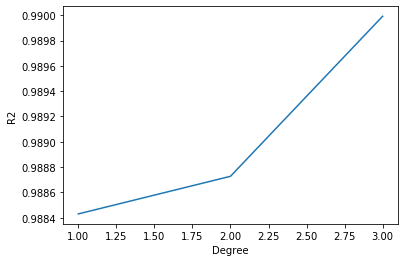

In [38]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "R2", markers = True)

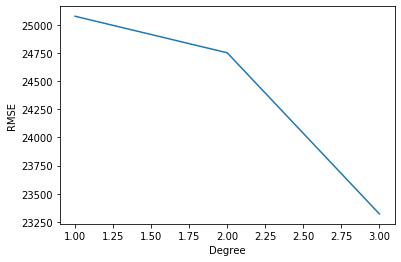

In [39]:
sns.lineplot(data = poly_train_result, x = "Degree", y = "RMSE", markers = True)

In [40]:
# from the figure above, the best degree is 3
poly = PolynomialFeatures(degree = 3)
poly_x_train = poly.fit_transform(x_train)
poly_x_test = poly.fit_transform(x_test)
poly_reg = LinearRegression()
poly_reg.fit(poly_x_train, y_train)
    
print("Performance on Training set:")
get_metrics(poly_x_train, y_train, poly_reg, "Polynomial Regression", False)
print("\nPerformance on Testing set:")
get_metrics(poly_x_test, y_test, poly_reg, "Polynomial Regression", True)

Performance on Training set:
RMSE: 23321.412346781362 
R2 score: 0.9899919707743805

Performance on Testing set:
RMSE: 25392.872917810844 
R2 score: 0.9882831411814745


## 3.3 Ridge

In [41]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train ridge model
    ridge = Ridge(alpha = n)
    ridge.fit(x_train, y_train)
    
    # rmse, r2 for train
    ridge_train_predict = ridge.predict(x_train)
    ridge_train_mse = mean_squared_error(y_train, ridge_train_predict)
    ridge_train_rmse = (np.sqrt(ridge_train_mse))
    ridge_train_r2 = r2_score(y_train, ridge_train_predict)
    
    dic[n] = [n, ridge_train_rmse, ridge_train_r2]
    
ridge_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(ridge_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,25074.950426,0.988430
0.010,25074.950426,0.988430
0.100,25074.950493,0.988430
10.000,25075.620774,0.988430
30.000,25080.942667,0.988425
50.000,25091.486310,0.988415
60.000,25098.685202,0.988408
70.000,25107.152686,0.988401
80.000,25116.876838,0.988392


In [42]:
# from the table above, when alpha = 0.01, the ridge performs best

# train ridge model
ridge = Ridge(alpha = 0.01)
ridge.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, ridge, "Ridge", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, ridge, "Ridge", True)

Performance on Training set:
RMSE: 25074.95042619734 
R2 score: 0.9884303815836171

Performance on Testing set:
RMSE: 22472.323251925234 
R2 score: 0.990823364847626


## 3.4 Lasso

In [43]:
dic = {}
for n in [0.001, 0.01, 0.1, 10, 30, 50, 60, 70, 80, 90, 100]:
    
    # train lasso model
    lasso = Lasso(alpha = n)
    lasso.fit(x_train, y_train)
    
    # rmse, r2 for train
    lasso_train_predict = lasso.predict(x_train)
    lasso_train_mse = mean_squared_error(y_train, lasso_train_predict)
    lasso_train_rmse = (np.sqrt(lasso_train_mse))
    lasso_train_r2 = r2_score(y_train, lasso_train_predict)
    
    dic[n] = [n, lasso_train_rmse, lasso_train_r2]
    
lasso_train_result = pd.DataFrame.from_dict(dic, orient = 'index', 
                                            columns = ["Lambda", "RMSE", "R_2"])
display(lasso_train_result.set_index("Lambda"))

,RMSE,R_2
Lambda,,
0.001,25074.950426,0.988430
0.010,25074.950426,0.988430
0.100,25074.950429,0.988430
10.000,25074.980461,0.988430
30.000,25076.747790,0.988429
50.000,25081.694538,0.988424
60.000,25084.020971,0.988422
70.000,25084.393207,0.988422
80.000,25084.808684,0.988421


In [44]:
# from the table above, when alpha = 0.01, the lasso performs best

# train ridge model
lasso = Lasso(alpha = 0.01)
lasso.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, lasso, "Lasso", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, lasso, "Lasso", True)

Performance on Training set:
RMSE: 25074.95042555567 
R2 score: 0.9884303815842092

Performance on Testing set:
RMSE: 22472.320401338875 
R2 score: 0.9908233671757154


## 3.5 Decision Tree Regression

In [45]:
def cross_validation_on_regression_tree(x, y, depths, cv):
    cv_scores_list = []

    for i in depths:
        tree_model = DecisionTreeRegressor(max_depth = i)
        cv_score = cross_val_score(tree_model, x, y, cv=cv, scoring = "r2").mean()
        cv_scores_list.append(cv_score)
    return cv_scores_list

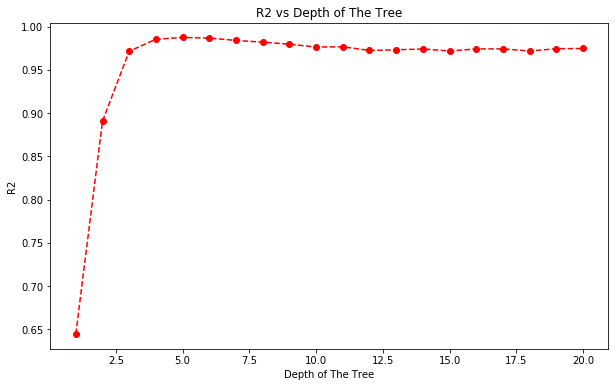

In [46]:
plt.figure(figsize = (10, 6))
cv_score_list = cross_validation_on_regression_tree(x_train, y_train, range(1, 21), 10)

plt.plot(range(1, 21), cv_score_list, color = "red", marker = 'o', linestyle = '--')  
plt.xlabel('Depth of The Tree')
plt.ylabel('R2')
plt.title('R2 vs Depth of The Tree')
plt.show()

In [47]:
# from the figure, the regression tree performs best at depth 6
reg_tree = DecisionTreeRegressor(max_depth = 6)
reg_tree.fit(x_train, y_train)

print("Performance on Training set:")
get_metrics(x_train, y_train, reg_tree, "Regression Tree", False)
print("\nPerformance on Testing set:")
get_metrics(x_test, y_test, reg_tree, "Regression Tree", True)

Performance on Training set:
RMSE: 22036.842794444543 
R2 score: 0.9910641140666274

Performance on Testing set:
RMSE: 26767.697748430488 
R2 score: 0.986980042755921


In [48]:
result = pd.DataFrame.from_dict(result_dic, orient = 'index', 
                                columns = ["Model", "RMSE", "R_2"])
display(result.set_index("Model"))

,RMSE,R_2
Model,,
Linear Regression,22472.320528,0.990823
Polynomial Regression,25392.872918,0.988283
Ridge,22472.323252,0.990823
Lasso,22472.320401,0.990823
Regression Tree,26767.697748,0.986980
